PyAutoFit
=========

**PyAutoFit** is a probabilistic programming language which makes is simple to compose, customize and fit complex
models to data.

To illustrate the **PyAutoFit** API, we'll use an illustrative toy model of fitting a one-dimensional Gaussian to
noisy 1D data.

Lets first import autofit and the other libraries we'll need.

In [1]:
# The 5 lines below set up the notebook working directory and can be ignored for the overview.

%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to {workspace_path}")

import autofit as af
import autofit.plot as aplt
import numpy as np
import matplotlib.pyplot as plt
from os import path

C:\Users\Jammy\Code\PyAuto\autofit_workspace
Working Directory has been set to C:\Users\Jammy\Code\PyAuto\autofit_workspace


2021-09-12 16:51:14,657 - autoconf.conf - WARNING - Pushing new config with path C:\Users\Jammy\Code\PyAuto\PyAutoFit\autofit\config


Simple Model
------------

We now load and plot the ``data`` we'll fit:

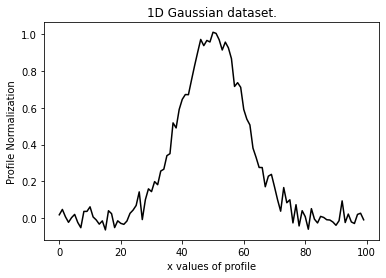

In [2]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

xvalues = np.arange(data.shape[0])
plt.plot(xvalues, data, color="k")
plt.title("1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Normalization")
plt.show()

We define our model, a 1D Gaussian, by writing a Python class using the format below:

In [3]:
class Gaussian:

    def __init__(
        self,
        centre=0.0,  # <- PyAutoFit recognises these
        normalization=0.1,  # <- constructor arguments are
        sigma=0.01,  # <- the Gaussian's parameters.
    ):
        self.centre = centre
        self.normalization = normalization
        self.sigma = sigma

    """
    An instance of the Gaussian class will be available during model fitting.

    This method will be used to fit the model to data and compute a likelihood.
    """

    def model_data_1d_via_xvalues_from(self, xvalues):

        transformed_xvalues = np.subtract(xvalues, self.centre)

        return np.multiply(
            np.divide(self.normalization, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )


By writing the `Gaussian` class in this way, PyAutoFit treats it as a *model-component* which can be fitted to data
via a `NonLinearSearch`.

PyAutoFit calls this a `Model` and it can generate instances of the class from custom *priors*.

In [4]:
model = af.Model(Gaussian)

model.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.normalization = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.sigma = af.GaussianPrior(mean=10.0, sigma=5.0)

print("Model `Gaussian` object: \n")
print(model)

print("\n Model `Gaussian` Parameters: \n")
print(model.centre)
print(model.normalization)
print(model.sigma)

Model `Gaussian` object: 

Gaussian (centre, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (normalization, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (sigma, GaussianPrior, mean = 10.0, sigma = 5.0)

 Model `Gaussian` Parameters: 

UniformPrior, lower_limit = 0.0, upper_limit = 100.0
UniformPrior, lower_limit = 0.0, upper_limit = 100.0
GaussianPrior, mean = 10.0, sigma = 5.0


All of the information about the model can be printed at once using its `info` attribute:

In [ ]:
print(model.info)

Using this `Model` we can create an `instance` of the model, by mapping a list of unit values to physical values
via the prior on each parameter.

In [5]:
instance = model.instance_from_unit_vector(unit_vector=[0.5, 0.5, 0.5])

print("Model Instance: \n")
print(instance)

print("\nInstance Parameters: \n")
print("x = ", instance.centre)
print("normalization = ", instance.normalization)
print("sigma = ", instance.sigma)

Model Instance: 


Instance Parameters: 

x =  50.0
normalization =  50.0
sigma =  10.0


This instance of the `Gaussian` class contains the functionality of its original class, for example
the `model_data_1d_via_xvalues_from` function:

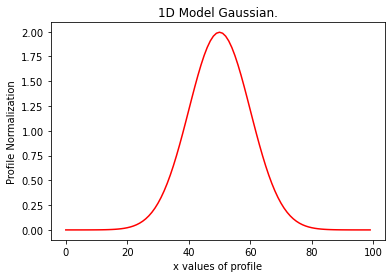

In [6]:
profile = instance.model_data_1d_via_xvalues_from(xvalues=xvalues)

plt.plot(xvalues, profile, color="r")
plt.title("1D Model Gaussian.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Normalization")
plt.show()

A *model* fit now only requires that a **PyAutoFit** ``Analysis`` class is written, which combines the data, model and
likelihood function and defines how the *model-fit* is performed using a `NonLinearSearch`.

In [7]:
class Analysis(af.Analysis):

    def __init__(self, data, noise_map):

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance):

        """
        The 'instance' that comes into this method is an instance of the Gaussian class
        above, with the parameters set to values chosen by the non-linear search.

        (The lines below are commented out to text printing later in the Notebook. They
        illustrate how model parameters are passed to the `log_likelihood_function`
        """

        # print("Gaussian Instance:")
        # print("Centre = ", instance.centre)
        # print("Normalization = ", instance.normalization)
        # print("Sigma = ", instance.sigma)

        """
        We fit the data with the Gaussian instance, using its
        "model_data_1d_via_xvalues_from" function to create the model data.
        """

        xvalues = np.arange(self.data.shape[0])

        model_data = instance.model_data_1d_via_xvalues_from(xvalues=xvalues)
        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        log_likelihood = -0.5 * sum(chi_squared_map)

        return log_likelihood


The ``Analysis`` class provides a model specific interface between **PyAutoFit** and the modeling software, allowing
it to handle the 'heavy lifting' that comes with writing *model-fitting* software. This includes interfacing with the
non-linear search, model-specific visualization during and the option of outputting results to a queryable database.

Performing a fit with a non-linear search, for example `dynesty` (https://github.com/joshspeagle/dynesty),
is performed as follows:

In [8]:
model = af.Model(Gaussian)

analysis = Analysis(data=data, noise_map=noise_map)

print("Non-linear search running, this will take a minute or so.... \n")

search = af.DynestyStatic(nlive=50)
result = search.fit(model=model, analysis=analysis)

print("Non-linear search complete!")

Non-linear search running, this will take a minute or so.... 

2021-09-12 16:51:16,601 - autofit.non_linear.abstract_search - INFO - Creating search
2021-09-12 16:51:16,602 - example_simple - INFO - Starting search
2021-09-12 16:51:16,607 - example_simple - INFO - Saving path info
2021-09-12 16:51:16,617 - example_simple - INFO - Not complete. Starting non-linear search.
2021-09-12 16:51:16,619 - example_simple - INFO - number_of_cores == 1...
2021-09-12 16:51:16,620 - example_simple - INFO - ...not using pool
2021-09-12 16:51:16,622 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2021-09-12 16:51:16,643 - example_simple - INFO - No Dynesty samples found, beginning new non-linear search. 
2021-09-12 16:51:21,017 - example_simple - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-09-12 16:51:22,041 - example_simple - INFO - 10000 Iterations: Performing update 

788it [00:04, 188.07it/s, +50 | bound: 39 | nc: 1 | ncall: 5052 | eff(%): 16.587 | loglstar:   -inf < -46.308 <    inf | logz: -63.429 +/-  0.843 | dlogz:  0.086 >  0.059]
1012it [00:00, 1443.10it/s, +50 | bound: 49 | nc: 1 | ncall: 5818 | eff(%): 18.254 | loglstar:   -inf < -46.251 <    inf | logz: -63.434 +/-  0.794 | dlogz:  0.001 >  0.059]
1012it [00:00, 1032506.85it/s, +50 | bound: 49 | nc: 1 | ncall: 5818 | eff(%): 18.254 | loglstar:   -inf < -46.251 <    inf | logz: -63.434 +/-  0.794 | dlogz:  0.001 >  0.059]


The result object returned by the fit provides information on the results of the non-linear search.

The `info` attribute shows the model in a readable format, including the priors specified above:

In [ ]:
print(result.info)

We can inspect the result's maximum likelihood instance, which is contained in its `Samples` object..

In [9]:
samples = result.samples

max_log_likelihood_instance = samples.max_log_likelihood()

print(max_log_likelihood_instance)

print("\n Model-fit Max Log-likelihood Parameter Estimates: \n")
print("Centre = ", result.max_log_likelihood_instance.centre)
print("Normalization = ", result.max_log_likelihood_instance.normalization)
print("Sigma = ", result.max_log_likelihood_instance.sigma)


 Model-fit Max Log-likelihood Parameter Estimates: 

Centre =  49.87536218548179
Normalization =  25.24493233392997
Sigma =  10.099733805147636


We can plot this over our data to see the model indeed gives a good fit.

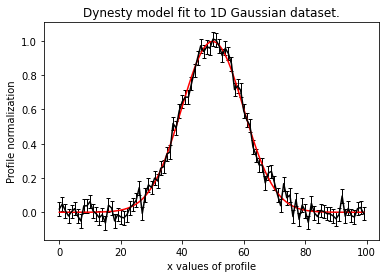

In [10]:
model_data = result.max_log_likelihood_instance.model_data_1d_via_xvalues_from(
    xvalues=np.arange(data.shape[0])
)
plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(xvalues, model_data, color="r")
plt.title("Dynesty model fit to 1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile normalization")
plt.show()
plt.close()

The Probability Density Functions (PDF's) of the results can be plotted using Dynesty's in-built visualization tools,
which are wrapped via the `DynestyPlotter` object.

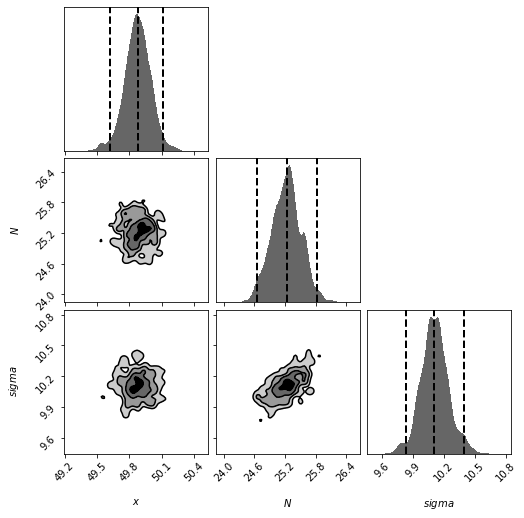

In [11]:
search_plotter = aplt.DynestyPlotter(samples=result.samples)
search_plotter.cornerplot()

The non-linear search `dynesty` above did not output results to hard-disk, which for quick model-fits and
experimenting with different models is desirable.

For many problems it is preferable for all results to be written to hard-disk. The benefits of doing this include:

- Inspecting results in an ordered directory structure can be more efficient than using a Jupyter Notebook.
- Results can be output on-the-fly, to check that a fit is progressing as expected mid way through.
- An unfinished run can be resumed where it was terminated.
- Additional information about a fit (e.g. visualization) can be output.
- On high performance computers which use a batch system, this is the only way to transfer results.

Any model-fit performed by **PyAutoFit** can be saved to hard-disk, by simply giving the non-linear search a
`name`. A `path_prefix` can optionally be input to customize the output directory.

In [ ]:
print("Non-linear search running, this will take a minute or so.... \n")

search = af.DynestyStatic(
    path_prefix=path.join("folder_0", "folder_1"),
    name="example_simple",
    nlive=50
)
result = search.fit(model=model, analysis=analysis)

print("Non-linear search complete!")

In the `autofit_workspace/output` directory you should find a folder containing the results of the model-fit
for inspection, including text files containing the `model.info`, `results.info` and other information.

The results are in a folder which is a collection of random characters. This is the 'unique_identifier' of
the model-fit. This identifier is generated based on the model fitted and search used, such that an identical
combination of model and search generates the same identifier. This ensures that rerunning an identical fit will
use the existing results to resume the model-fit.

Complex Model
-------------

It is straight forward to compose and customize more complex models with **PyAutoFit**.  To demonstrate this, we'll
fit another 1D dataset that contains a Gaussian's and a symmetric Exponential profile.

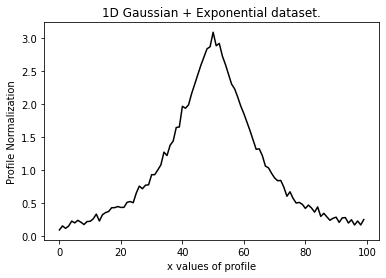

In [12]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1__exponential_x1")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

xvalues = np.arange(data.shape[0])
plt.plot(xvalues, data, color="k")
plt.title("1D Gaussian + Exponential dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Normalization")
plt.show()

To fit the Exponential, we define a second Python class which will act as a *model-component* like the Gaussian did
previously.

In [13]:
class Exponential:

    def __init__(
        self,
        centre=0.0,     # <- PyAutoFit recognises these constructor arguments are the model
        normalization=0.1,  # <- parameters of the Exponential.
        rate=0.01,
    ):
        """Represents a 1D Exponential profile symmetric about a centre, which may be treated as a model-component
        of PyAutoFit the parameters of which are fitted for by a non-linear search.

        Parameters
        ----------
        centre
            The x coordinate of the profile centre.
        normalization
            Overall normalization normalisation of the `Gaussian` profile.
        ratw
            The decay rate controlling has fast the Exponential declines.
        """
        self.centre = centre
        self.normalization = normalization
        self.rate = rate

    def model_data_1d_via_xvalues_from(self, xvalues):
        """
        Calculate the normalization of the profile on a line of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Exponential, using its centre.

        Parameters
        ----------
        values
            The x coordinates in the original reference frame of the grid.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return self.normalization * np.multiply(
            self.rate, np.exp(-1.0 * self.rate * abs(transformed_xvalues))
        )

We can compose a model from multiple *model-components* using the `Collection` object.

In [14]:
model = af.Collection(gaussian=Gaussian, exponential=Exponential)

All of the information about this more complex model can be printed using its `info` attribute:

In [ ]:
print(model.info)

An `instance` of the model can be created like we did for a `Model` above.

In [15]:
instance = model.instance_from_vector(vector=[0.1, 0.2, 0.3, 0.4, 0.5, 0.01])

print("Instance Parameters \n")
print("x (Gaussian) = ", instance.gaussian.centre)
print("normalization (Gaussian) = ", instance.gaussian.normalization)
print("sigma (Gaussian) = ", instance.gaussian.sigma)
print("x (Exponential) = ", instance.exponential.centre)
print("normalization (Exponential) = ", instance.exponential.normalization)
print("sigma (Exponential) = ", instance.exponential.rate)

Instance Parameters 

x (Gaussian) =  0.1
normalization (Gaussian) =  0.2
sigma (Gaussian) =  0.3
x (Exponential) =  0.4
normalization (Exponential) =  0.5
sigma (Exponential) =  0.01


There are many options for customizing a model, below we require that:

- The `Gaussian` and `Exponential` share the same centre (reducing the dimensionality of parameter space by 1).
- That the `Gaussian`'s `sigma` value is 10.0 (again reducing the dimensionality by 1).
- That the `rate` parameter of the `Exponential` is above 0.0.

In [16]:
model.gaussian.centre = model.exponential.centre
model.gaussian.sigma = 10.0
model.exponential.add_assertion(model.exponential.rate > 0.0)

We see these model customizations reflected in the `info` attribute:

In [ ]:
print(model.info)

The `Analysis` class above was written assuming the input `instance` contained only a single `Gaussian` profile. The
`Collection` contains multiple profiles, thus we must update the `Analysis` class to reflect this.

In [17]:
class Analysis(af.Analysis):

    def __init__(self, data, noise_map):

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance):

        xvalues = np.arange(self.data.shape[0])

        """
        The instance, which now contains the `gaussian` and `exponential`, can be iterated over
        and summed so our model-data is the combination of the two.
        """

        model_data = sum(
            [profile.model_data_1d_via_xvalues_from(xvalues=xvalues) for profile in instance]
        )

        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        log_likelihood = -0.5 * sum(chi_squared_map)

        return log_likelihood

We can now fit our more complex model as we did previously. Lets use the MCMC algorithm
`Emcee` (https://github.com/dfm/emcee) this time.

In [18]:
analysis = Analysis(data=data, noise_map=noise_map)

print("Non-linear search running, this will take a minute or so.... \n")

search = af.Emcee(name="example_complex", nwalkers=30, nsteps=200)
result = search.fit(model=model, analysis=analysis)

print("Non-linear search complete!")

Non-linear search running, this will take a minute or so.... 

2021-09-12 16:51:38,686 - autofit.non_linear.abstract_search - INFO - Creating search
2021-09-12 16:51:38,688 - example_complex - INFO - Starting search
2021-09-12 16:51:38,692 - example_complex - INFO - Saving path info
2021-09-12 16:51:38,705 - example_complex - INFO - Not complete. Starting non-linear search.
2021-09-12 16:51:38,707 - example_complex - INFO - number_of_cores == 1...
2021-09-12 16:51:38,708 - example_complex - INFO - ...not using pool
2021-09-12 16:51:38,716 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2021-09-12 16:51:38,741 - example_complex - INFO - No Emcee samples found, beginning new non-linear search.
2021-09-12 16:51:42,182 - example_complex - INFO - 2500 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-09-12 16:51:43,405 - example_complex - INFO - Emcee sampling complete.
2021-0

100%|██████████| 200/200 [00:03<00:00, 58.57it/s]


We again print the result's `info` to see a summary of the results.

In [ ]:
print(result.info)

Because our fit used a `Collection` (as opposed to a `Model`) the `Result` instance returns the
results for both the `gaussian` and `exponential`.

In [19]:
samples = result.samples

max_log_likelihood_instance = samples.max_log_likelihood()

print(max_log_likelihood_instance)

print("Max Log Likelihood `Gaussian` Instance:")
print("Centre = ", max_log_likelihood_instance.gaussian.centre)
print("Normalization = ", max_log_likelihood_instance.gaussian.normalization)
print("Sigma = ", max_log_likelihood_instance.gaussian.sigma, "\n")
print("Max Log Likelihood Exponential Instance:")
print("Centre = ", max_log_likelihood_instance.exponential.centre)
print("Normalization = ", max_log_likelihood_instance.exponential.normalization)
print("Sigma = ", max_log_likelihood_instance.exponential.rate, "\n")

Max Log Likelihood `Gaussian` Instance:
Centre =  50.06566274749798
Normalization =  23.307841741378876
Sigma =  10.0 

Max Log Likelihood Exponential Instance:
Centre =  50.06566274749798
Normalization =  40.887884816774886
Sigma =  0.05165278497637013 



We can again use this to plot the model fit.

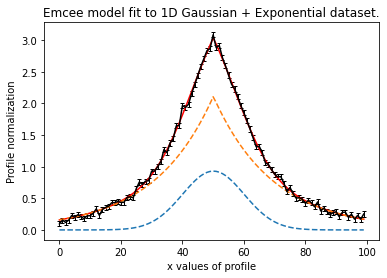

In [22]:
model_gaussian = max_log_likelihood_instance.gaussian.model_data_1d_via_xvalues_from(
    xvalues=np.arange(data.shape[0])
)
model_exponential = max_log_likelihood_instance.exponential.model_data_1d_via_xvalues_from(
    xvalues=np.arange(data.shape[0])
)
model_data = model_gaussian + model_exponential

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(range(data.shape[0]), model_data, color="r")
plt.plot(range(data.shape[0]), model_gaussian, "--")
plt.plot(range(data.shape[0]), model_exponential, "--")
plt.title("Emcee model fit to 1D Gaussian + Exponential dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile normalization")
plt.show()
plt.close()

The Probability Density Functions (PDF's) of the results can be plotted using the Emcee's visualization
tool `corner.py`, which is wrapped via the `EmceePlotter` object.

2021-09-12 16:52:17,689 - root - WARNING - Too few points to create valid contours


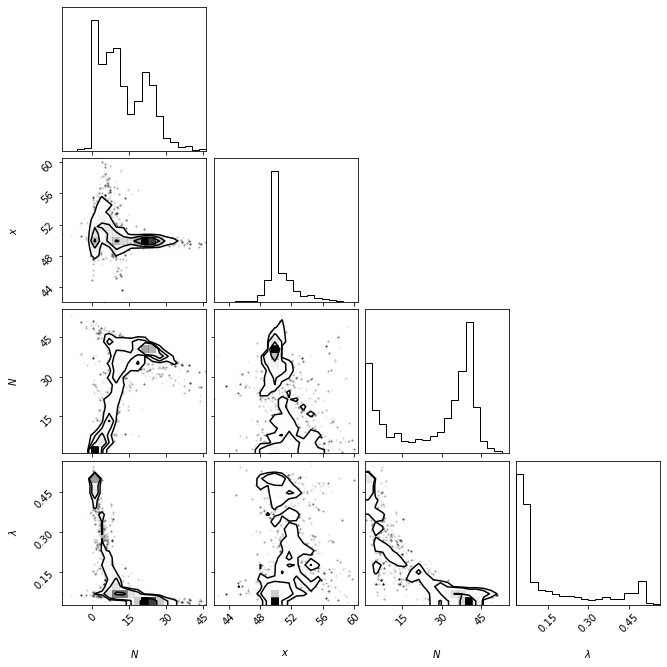

In [23]:
search_plotter = aplt.EmceePlotter(samples=result.samples)
search_plotter.corner()

Congratulations, you've  completed the **PyAutoFit** introduction!

So, What Next?
--------------

This notebook has given you an overview of the **PyAutoFit** API, which is expanded on throughout the workspace and
at the [following readthedocs page](https://pyautofit.readthedocs.io/en/latest/overview/model_fit.html).

This API acts as the foundation for using many of **PyAutoFit**'s advanced features, such as:

- [Database tools for loading and manipulating large libraries of results in a Jupyter notebook.](https://pyautofit.readthedocs.io/en/latest/features/database.html)
- [Fitting large datasets with a graphical model](https://pyautofit.readthedocs.io/en/latest/howtofit/chapter_graphical_models.html)
- [Performing massively parallel grid searches of non-linear searches.](https://pyautofit.readthedocs.io/en/latest/features/search_grid_search.html)
- [Chaining non-linear searches back-to-back to break a complex model-fits into sequences of simpler model-fits](https://pyautofit.readthedocs.io/en/latest/features/search_chaining.html)
- [Sensitivity mapping over a model or dataset to determine when complex model features become detectable](https://pyautofit.readthedocs.io/en/latest/features/sensitivity_mapping.html)

We recommend you next start the **HowToFit** Jupyter notebook lectures, which provide a detailed description of the
**PyAutoFit** API, give more details on how to compose and fit models and a more detailed description of the
`Result` object and database analysis tools.

The `autofit_workspace/*/model` package also provides cookbooks that act as a concise API reference for model composition.

If you wish to add your own *model-component* to your `autofit_workspace` to perform your own model-fitting task,
checkout the script `autofit_workspace/*/overview/new_model_component/new_model_compnent.ipynb`, which explains
how to set up the **PyAutoFit** configuration files associated with your model.

You can install **PyAutoFit** on your system and clone the `autofit_workspace` and `howtofit` tutorials
following the instructions on our readthedocs:

 https://pyautofit.readthedocs.io/en/latest/installation/overview.html

Alternatively, you can begin the tutorials on Binder by going to the folder `howtofit/chapter_1_introduction` at
the following link `https://mybinder.org/v2/gh/Jammy2211/autofit_workspace/HEAD`.